# Homework 3

**The Barnstable Case**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)
plt.style.use("seaborn")
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Part 3

- For the full sample of market returns, **1926-2021**, calculate the level excess returns not (log returns). 

In [2]:
filepath = "C:/Users/dcste/OneDrive/Portfolio_Theory/Homework_Jupyter/portfolio_theory/barnstable_analysis_data (1).xlsx"
descrip = pd.read_excel(filepath, sheet_name = "descriptions")
descrip = descrip.rename(columns={"Unnamed: 0":"Ticker"})
descrip.head()

,Ticker,Description
0,SPX,S&P500 Index
1,TB1M,Treasury Bill (1M) Index


In [3]:
returns = pd.read_excel(filepath, sheet_name="data").rename(columns = {"date": "Date"}).set_index("Date")
returns["Level"] = returns["SPX"] - returns["TB1M"]
returns.dropna(inplace = True)
returns.head()

,SPX,TB1M,Level
Date,,,
1926-01-30,-0.0018,0.0031,-0.0048
1926-02-27,-0.0333,0.0026,-0.0359
1926-03-31,-0.0577,0.0026,-0.0603
1926-04-30,0.0385,0.0023,0.0363
1926-05-28,0.0136,0.0027,0.0109


## Question 1

1. **Historical VaR**
Starting at $t=61$, calculate the historic based **VaR**, based on expanding the sample period from $1$ (Jan 1926) to $t-1$.

    1. Plot the historical **VaR** over time. 
    2. Calculate the frequency of periods where the actual level returns are less than the historical Value at Risk. 
    3. What drawbacks do you see from this VaR.

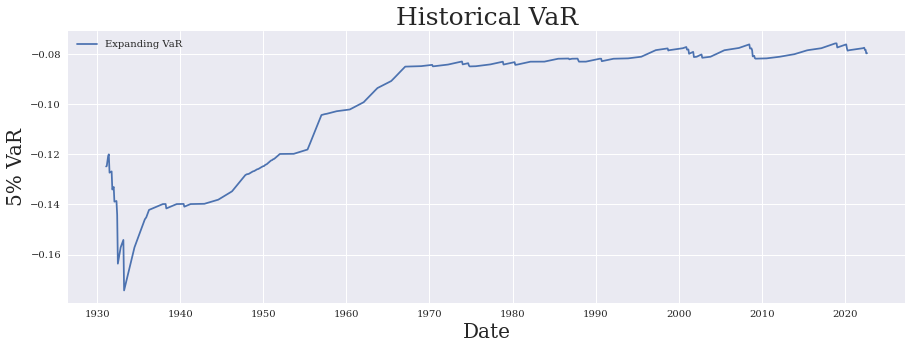

In [4]:
historical_var = pd.Series(returns["Level"].shift().expanding(min_periods = 60).quantile(.05), name = "Expanding Var")


plt.figure(figsize = (15,5))
plt.plot(historical_var, label = "Expanding VaR")
plt.xlabel("Date", size = 20)
plt.ylabel("5% VaR", size = 20)
plt.title("Historical VaR", size = 25)
plt.legend(loc = 0)

In [5]:
# Calculate the frequency the actual historical risk premium is less than the historical value at risk
frequency = len(returns[returns["Level"] < historical_var])/len(historical_var.dropna())
print("The frequency in which the actual return is lower than the 5% Value at Risk is {}%".format(round(frequency, 4)*100))

The frequency in which the actual return is lower than the 5% Value at Risk is 3.0300000000000002%


Theoretically, we should see that about 5% of all returns are lower than the 5% **Value at Risk** measure, however, **empirically** we see that $2.88$% of the total level returns were less than the 5% value at risk measure. This means the return tails are skewwed. 

## Question 2 Volatility

- We will calculate a time-series of volatility estimates using a few different methods:

**Expanding Volatility**

$\sigma^2_t = \frac{1}{t-1}\sum_{i=1}^{t-1}r^2_i$

- If we begin at $t=61$, our first estimate is based on 60 data points.

**Rolling Volatitlity**
$\sigma^2_t = \frac{1}{m}\sum_{i=1}^mr^2_{t-i}$

- If we begin at $m = 60$ so our first calculation of the rolling volatility is at $t=61$ and has a full 60 data points

**Exponentially Weighted Moving Average**

$\sigma^2_t = \sum_{i=1}^{\N-1}\lambda^{(i-1)} r^2_{t-i}$

- Rather than estimating lambda, simply use $\lambda = .97$ and initialize $\sigma_{1} = .15$

**GARCH(1,1)**

*Generalized AutoRegressive Conditional Heteroskedastic Model*

$\sigma^2_t = \alpha_0 + \gamma_1\sigma^2_{t-1} + \alpha_1 r^2_{t-1}$

- To estimate *GARCH(1,1)* use the **ARCH** package in python


- Estimate all of these time-series volatility estimates using the different methods. 


<AxesSubplot:xlabel='Date'>

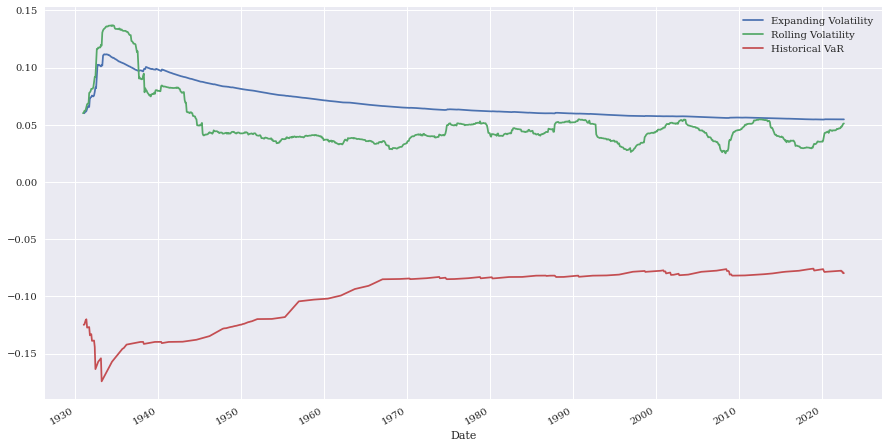

In [6]:
stdv = np.sqrt((returns["Level"]**2).shift(1).expanding(min_periods=60).mean().to_frame("Expanding Volatility"))
stdv["Rolling Volatility"] = np.sqrt((returns["Level"]**2).rolling(60).mean())
stdv["Historical VaR"] = historical_var
stdv.plot(figsize = (15,8))


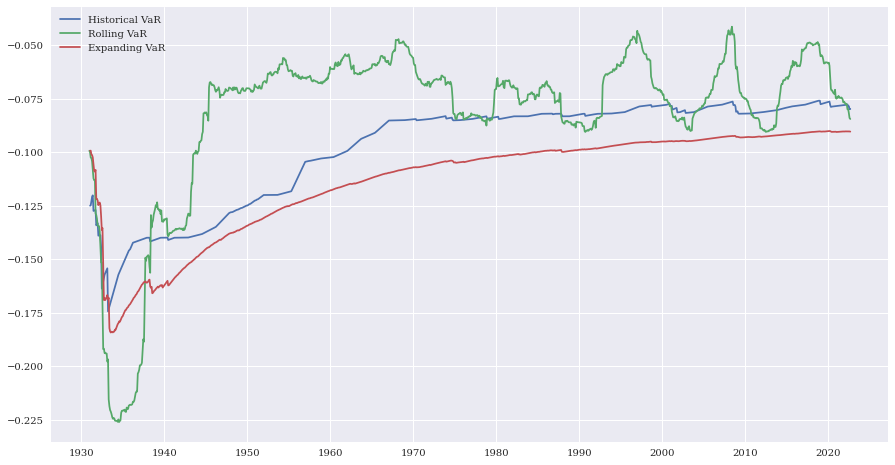

In [7]:
stdv["Expanding Var"] = stdv["Expanding Volatility"]*-1.65
stdv["Rolling VaR"] = stdv["Rolling Volatility"]*-1.65

plt.figure(figsize=(15,8))
plt.plot(stdv["Historical VaR"], label ="Historical VaR")
plt.plot(stdv["Rolling VaR"], label = "Rolling VaR")
plt.plot(stdv["Expanding Var"], label = "Expanding VaR")
plt.legend(loc = 0)

In [20]:
stdv["Excess Returns"] = returns["Level"]
stdv.head()

,Expanding Volatility,Rolling Volatility,Historical VaR,Expanding Var,Rolling VaR,Excess Returns,GARCH,EWMA
Date,,,,,,,,
1931-01-31,0.0601,0.0606,-0.1249,-0.0992,-0.1000,0.0585,0.0744,0.0869
1931-02-28,0.0601,0.0621,-0.1247,-0.0992,-0.1024,0.1097,0.0726,0.0862
1931-03-31,0.0612,0.0622,-0.1227,-0.1010,-0.1027,-0.0697,0.0768,0.087
1931-04-30,0.0614,0.0632,-0.1208,-0.1013,-0.1043,-0.0936,0.0758,0.0865
1931-05-29,0.0620,0.0657,-0.1201,-0.1023,-0.1083,-0.1381,0.0774,0.0868


For each of the three volatility based estimates, calculate the frequency of periods in which the historical volatility is less than the estimated VaR

In [21]:

Expanding_Var_Freq = len(stdv[stdv["Excess Returns"] < stdv["Expanding Var"]])/len(stdv.dropna())
Rolling_Var_Freq = len(stdv[stdv["Excess Returns"] < stdv["Rolling VaR"]])/len(stdv.dropna())
pd.DataFrame([frequency, Expanding_Var_Freq,Rolling_Var_Freq], index = ["Historical Var","Expanding Var Frequency", "Rolling Var Frequency"], columns=["Frequency Historical Var < Estimated"])

,Frequency Historical Var < Estimated
Historical Var,0.0303
Expanding Var Frequency,0.0175
Rolling Var Frequency,0.0496


From the frequencies above, we see the Rolling Value at Risk Measure is the best one because its closest to the actual theoretical 5% Value at Risk Measure.

In [10]:
# Estimating EWMA

IGARCH = arch_model(returns["Level"])
theta = 0.97
IGARCH.volatility = EWMAVariance(theta)
IGARCH_model = IGARCH.fit()
IGARCH_model

Iteration:      1,   Func. Count:      3,   Neg. LLF: 3984570.5364937778
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1858.8039187809004
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1858.8039187817976
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2


                Constant Mean - EWMA/RiskMetrics Model Results                
Dep. Variable:                  Level   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:           EWMA/RiskMetrics   Log-Likelihood:                1858.80
Distribution:                  Normal   AIC:                          -3715.61
Method:            Maximum Likelihood   BIC:                          -3710.56
                                        No. Observations:                 1148
Date:                Mon, Dec 05 2022   Df Residuals:                     1147
Time:                        15:37:55   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.0151e-03  1.487e-03      4.718  2.376e-06 [4.

In [11]:
GARCH = arch_model(returns["Level"], vol = "Garch", p = 1, o = 0, q = 1, dist = "Normal")
GARCH_model = GARCH.fit()
GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 38084950.95951727
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1909.9199599735189
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1909.9199630529993
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


mu          7.8426e-03
omega       5.8962e-05
alpha[1]    1.0000e-01
beta[1]     8.8000e-01
Name: params, dtype: float64

In [12]:
stdv[["GARCH", "EWMA"]] = None
stdv.iloc[0,2:] = 0.15
for i in range(1,len(stdv)):
    stdv["EWMA"].iloc[i] = np.sqrt((stdv["EWMA"].iloc[i-1]**2 * theta) + (1-theta)*(returns["Level"].iloc[i-1]**2)) 
    stdv["GARCH"].iloc[i] = np.sqrt(GARCH_model.params["omega"] + (stdv["GARCH"].iloc[i-1]**2)*GARCH_model.params['beta[1]'] + GARCH_model.params["alpha[1]"]*(returns["Level"].iloc[i-1]**2))
stdv.dropna(inplace = True)

Text(0.5, 1.0, '$\\sigma_{t}$ Extrapolation')

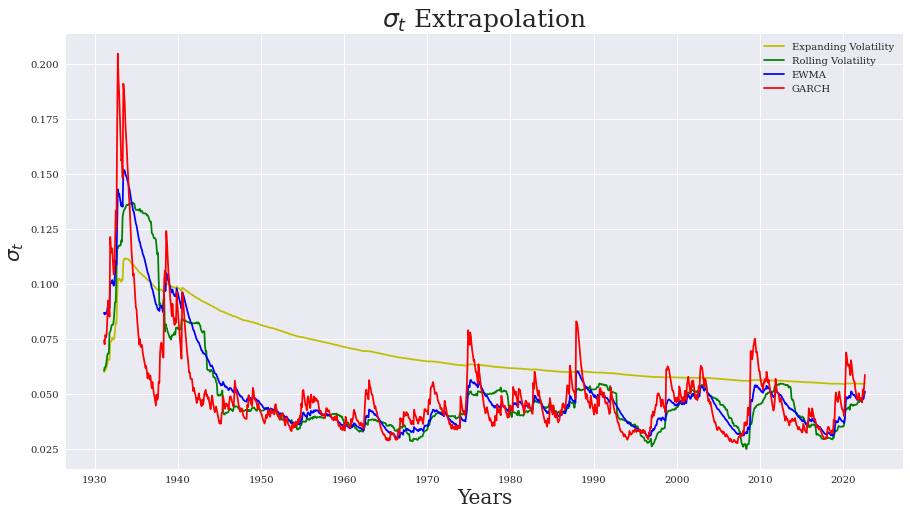

In [13]:
plt.figure(figsize = (15,8))
plt.plot(stdv["Expanding Volatility"], label = "Expanding Volatility", c= "y")
plt.plot(stdv["Rolling Volatility"], label = 'Rolling Volatility', c = "g")
plt.plot(stdv["EWMA"], label = "EWMA", c = "b")
plt.plot(stdv["GARCH"], label = "GARCH", c = "r")
plt.legend(loc = 0)
plt.xlabel("Years", size = 20)
plt.ylabel(r"$\sigma_{t}$", size = 20)
plt.title(r'$\sigma_{t}$ Extrapolation', size = 25)

In [14]:
Vol_Estimates = stdv[["Expanding Volatility","Rolling Volatility", "GARCH", "EWMA"]]

For each method, calculate the 5th percentile, 1-month ahead VaR. We use a slighly simpler *VaR* calculation by dropping $\mu$ from that formula, and rounding the normal distribution $z$-score to $-1.65$

In [15]:
def vol_calcuation(df, VaR = -1.65):
    forecasted_val = pd.DataFrame(data = None, index = df.columns, columns = ["VaR Risk Forecast"])
    last_obs = len(df)
    for col in df.columns:
        forecasted_val.loc[col,"VaR Risk Forecast"] = df[col].iloc[last_obs-1]*VaR
        forecasted_val.loc[col, "Month"] = df.index[last_obs-1]

    return round(forecasted_val, 4)

In [16]:
vol_calcuation(Vol_Estimates, VaR = -1.65)

,VaR Risk Forecast,Month
Expanding Volatility,-0.0903,2022-08-31
Rolling Volatility,-0.0844,2022-08-31
GARCH,-0.0968,2022-08-31
EWMA,-0.0841,2022-08-31


In [17]:
stdv.head()

,Expanding Volatility,Rolling Volatility,Historical VaR,Expanding Var,Rolling VaR,Excess Returns,GARCH,EWMA
Date,,,,,,,,
1931-01-31,0.0601,0.0606,-0.1249,-0.0992,-0.1000,0.0585,0.0744,0.0869
1931-02-28,0.0601,0.0621,-0.1247,-0.0992,-0.1024,0.1097,0.0726,0.0862
1931-03-31,0.0612,0.0622,-0.1227,-0.1010,-0.1027,-0.0697,0.0768,0.087
1931-04-30,0.0614,0.0632,-0.1208,-0.1013,-0.1043,-0.0936,0.0758,0.0865
1931-05-29,0.0620,0.0657,-0.1201,-0.1023,-0.1083,-0.1381,0.0774,0.0868


In [23]:
VaR = stdv[['Historical VaR', "Expanding Var",'Rolling VaR']]

For each of these three vol-based VaR estimates, calculate the frequency of periods in which the actual VaR is less than the historical **VaR**.

In [24]:
freq = pd.DataFrame(data = None, index = ["Frequency"], columns = VaR.columns)
for col in freq:
    freq[col] = len(VaR[returns.loc[VaR.index,"Level"] < VaR[col]])/len(VaR[col].dropna().index)
round(freq, 4)

,Historical VaR,Expanding Var,Rolling VaR
Frequency,0.0303,0.0175,0.0496


Obviously, here the *GARCH* model outperforms all the other volitility estimates. 

## CVaR

Re-do the previousl to problems, but this time calculate **CVaR** instead of **VaR.**

- Calculate CVaR for the empirical cdf
- The normal model, using expanding volatility estimates
- The normal model, using rolling volatility estimates


Here's the formula for **CVaR**

- $CVaR_{\tau} =\;  \mu_{\tau,t} - \frac{Z_{score})}\sigma_{\tau,t}$

Heres the formula for **VAR**

$VaR_{qtau}= \mu_{\tau,t} + \underbrace{Z_{score}\sigma_{\tau,t}}$





In [19]:
print("The 5% Quantitle of a Normal Distribution is {} and the quantile -1.65 standard devations from the mean is {}".format(round(stats.norm.ppf(.05), 5), round(stats.norm.cdf(-1.65), 6)))


The 5% Quantitle of a Normal Distribution is -1.64485 and the quantile -1.65 standard devations from the mean is 0.049471


In [25]:
# Calculating CVaR for empirical CDF, expanding VOL, and rolling VOL
z_q = -1.65
q = 0.05
coef_CVaR = -stats.norm().cdf(z_q)/q
coef_CVaR

-0.989429360672962

In [26]:
stdv["Historical CVar"] = returns["Level"].expanding(min_periods = 60).apply(lambda x: x[x< x.quantile(.05)].mean()).shift()
stdv["Expanding CVaR"] = stdv["Expanding Volatility"]*coef_CVaR
stdv["Rolling CVaR"] = stdv["Rolling Volatility"]*coef_CVaR


<AxesSubplot:xlabel='Date'>

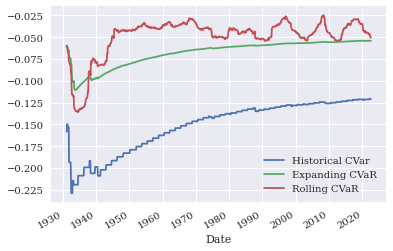

In [27]:
stdv[["Historical CVar", "Expanding CVaR", "Rolling CVaR"]].plot()

In [28]:
Historical_cvar_freq = len(stdv[stdv["Excess Returns"]<stdv["Historical CVar"]])/len(stdv)
Expanding_cvar_freq = len(stdv[stdv["Excess Returns"] < stdv["Expanding CVaR"]])/len(stdv)
Rolling_cvar_freq = len(stdv[stdv["Excess Returns"] < stdv["Rolling CVaR"]])/len(stdv)

pd.DataFrame([Historical_cvar_freq,Expanding_cvar_freq,Rolling_cvar_freq], index = ["Historical CVAR Frequency", "Expanding CVAR Frequency", "Rolling CVAR Frequency"], columns = ["Frequency of Actual Return Less than CVAR"])

,Frequency of Actual Return Less than CVAR
Historical CVAR Frequency,0.0083
Expanding CVAR Frequency,0.0708
Rolling CVAR Frequency,0.1176


## Estimating Underperformance

- Estimate the arithmetic returns and log returns in the different time frames

In [29]:

df2 = pd.read_excel(filepath, sheet_name="data").rename(columns = {"date": "Date"}).set_index("Date") 
level_data = df2
log_df = np.log(1+df2)

def annualized_stats(data, annual_factor = 12, log = False):
    if log == False:
        df = pd.DataFrame(data = None, index = ["Market Return", "Excess Return", "riskfree_return"])
    else:
        df = pd.DataFrame(data = None, index = ["log_Market Return", "log_Excess Return", "log_riskfree_return"])
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + ' mu'] = [data['SPX'].mean(),
                                                                                data['SPX'].mean()-data['TB1M'].mean(),
                                                                                data['TB1M'].mean()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + ' mu'] *= annual_factor
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + ' sigma'] = [data['SPX'].std(),
                                                                                   (data['SPX']-df2['TB1M']).std(),
                                                                                   data['TB1M'].mean()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + ' sigma'] *= np.sqrt(annual_factor)
    
    return df
    

In [30]:
def join(df_list):
    df = df_list[0]
    
    for df_ in df_list[1:]:
        df = df.join(df_)
    
    return df

In [31]:
stats_ = join([annualized_stats(level_data.loc['1965':'1999'], 12),
             annualized_stats(level_data.loc['2000':], 12),
             annualized_stats(level_data.loc['1926':], 12)])
log_stats = join([annualized_stats(log_df.loc['1965':'1999'], 12, log = True),
                 annualized_stats(log_df.loc['2000':], 12, log = True),
                 annualized_stats(log_df.loc['1926':], 12, log = True)])

stats_df = stats_.append(log_stats)
stats_df

,1965-1999 mu,1965-1999 sigma,2000-2022 mu,2000-2022 sigma,1926-2022 mu,1926-2022 sigma
Market Return,0.1294,0.1494,0.0759,0.1526,0.1135,0.1874
Excess Return,0.0679,0.1502,0.0616,0.1531,0.0819,0.1881
riskfree_return,0.0615,0.0178,0.0143,0.0041,0.0315,0.0091
log_Market Return,0.1176,0.1496,0.0640,0.1537,0.0957,0.1867
log_Excess Return,0.0563,0.1504,0.0497,0.1542,0.0642,0.1873
log_riskfree_return,0.0613,0.0177,0.0143,0.0041,0.0315,0.0091


- Calculate the probability that the cumlative market return will fall short of the cumulative risk-free return

In [32]:
def prob_calc(h, tilde_mu, tilde_sigma):
    return stats.norm.cdf((- np.sqrt(h) * tilde_mu) / tilde_sigma)
def prob(h, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])
    
    prob_df['Probability'] = prob_calc(prob_df['h'], tilde_mu, tilde_sigma)
    
    prob_df = prob_df.set_index('h')
    
    return prob_df

In [33]:
mu_tilde = stats_df.iloc[4, 0] # log rtM mu (return) Excess Returns mu
sigma_tilde = stats_df.iloc[4, 1] # log rtM sigma (volatility) Excess Returns sigma
h = 1999 - 1965

prob([h], mu_tilde, sigma_tilde)

,Probability
h,
34,0.0146


In [34]:
prob([15, 30], mu_tilde, sigma_tilde)

,Probability
h,
15,0.0736
30,0.0202


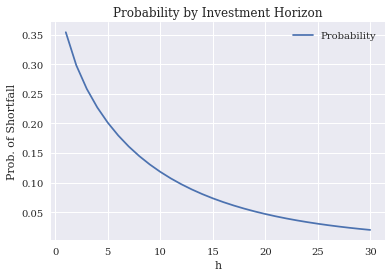

In [ ]:
prob_horizon = prob(list(range(1,31)), mu_tilde, sigma_tilde)

prob_horizon.plot() 
plt.title('Probability by Investment Horizon')
plt.ylabel('Prob. of Shortfall')
plt.show()

Use the sample 1965-2022 to reconsider the 30-year probability. As of the end of 2022, calculte the probability of the stock return underperforming the risk-free rate over the next 30 years. 

In [ ]:
log_df1965 = log_df.loc['1965':]
mu_t = (log_df1965['SPX'].mean()-log_df1965['TB1M'].mean()) * 12
sigma_t = (log_df1965['SPX']-log_df1965['TB1M']).std() * np.sqrt(12)

prob(list(range(5,35, 5)), mu_t, sigma_t)

,Probability
h,
5,0.2143
10,0.1315
15,0.0852
20,0.0567
25,0.0384
30,0.0263


## Question 4

1. What was the probability (based on the 1999 estimate of $\mu$), that the 23-year market return, would be smaller than that realized in 2000-2022? Note we are asking about the market return and not the excess market return. Continue using the 1965-1999 sample standard deviation for $\sigma$.

In [ ]:
mu = stats_df.iloc[3,0]
bar_r = stats_df.iloc[3,2] # 2000-2022 market return mu
sigma = stats_df.iloc[3,1] # 1965-1999 market return vol
prob([23], mu-bar_r, sigma)

,Probability
h,
23,0.0429


Suppose Barnstable sold puts with the growing strike price of 6% per year. Based on the 2000-2022 performance, what is the probability the 2000-2029 cumulative market return will be low enough for those puts to be in the money. 

In [35]:
# 4(b) 
# In this example, strike is the target we are calculating the odds of underperforming
strike = np.log(1.06)
# mu of all data, annualized
mu65 = log_df1965['SPX'].mean() * 12
# sigma of all data, annualized
sigma65 = log_df1965['SPX'].std() * np.sqrt(12)
# log market returns 2000-2022 - the first part makes up for any over/under performance in the first portion of the time horizon
mu = 23/7 * (stats_df.iloc[3, 2] - strike) + (mu65 - strike)

prob([7], mu, sigma65)

NameError: name 'log_df1965' is not defined